# Summary of Findings


### Introduction

In this project, I further expand on topics explored in the outages dataset from project 3. We will discuss a classification prediction problem that I became interested in while exploring the dataset previously. I am interested in whether or not an outage is severe based on its duration. In my last project I arbitrarily categorized major power outages as more severe and less severe depending on if the duration of the outages were higher or lower than the 75th percentile. Here, I want to predict whether a major power outage is less severe or more severe by creating models of our dataset, implementing sklearn pipelines and methods and engineering new features in order to streamline our modeling process.

Since this is a classification problem, I will be using the f1 score as an evaluation metric. Using the f1-score will give me a good combination of both precision and recall. I will be using both quantitative and categorical features to train my models.


### Baseline Model

In my baseline model I used seven generic features that I believed would be helpful in determining the severity/duration of outages: MONTH (categorical), U.S.\_STATE (categorical), CLIMATE.REGION (categorical), CLIMATE.CATEGORY (categorical), CAUSE.CATEGORY (categorical), DEMAND.LOSS.MW (quantitative), ANOMALY.LEVEL (quantitative), and CUSTOMERS.AFFECTED (quantitative). I dropped features that were unnecessary, and one-hot encoded the categorical features. 

I used a train-test split to separate my dataset into a training set and testing set, and then I used a DecisionTreeClassifier from sklearn with a max depth of 15 for the baseline model. My f1 score from this baseline model was around 0.5, which definitely could be improved. I would like it to be closer to one.

### Final Model

In my final model, I wanted to engineer some more features that could potentially benefit my classification. I created a new categorical column called 'seasons' by binning the months into either winter, spring, summer, and autumn. I then one-hot encoded the all of the categorical features. I also log-scaled both CUSTOMERS.AFFECTED and DEMAND.LOSS.MW. These added features are good for my data because within the MONTHS columns, the similarities across weather/climate patterns should be grouped into clumps depending on which season the month is in. After log-scaling CUSTOMERS.AFFECTED and DEMAND.LOSS.MW the columns showed a better relationship. 

Again, I used the DecisionTreeClassifier with the same max depth and got a slightly better f1 score of around 0.65-0.7. To explore parameter combinations, I used GridSearchCV from sklearn and found the best parameters to be: 'dtc__max_depth': 5, 'dtc__min_samples_leaf': 5, 'dtc__min_samples_split': 9.


### Fairness Evaluation

In this section, I evaluate my model for fairness on a subset of the dataset using a permutation test. 

I choose demand loss to construct my interesting subset. I can binarize my subset by putting the demand loss threshold at the median, so everything below the median is 'less' and everything above the median is 'more'. Now we have a less subset and more subset, which will be X and Y.

For my parity measure, I pick precision because this tells us the proportion of positive identifications that were correct. 

These are my null and alternative hypotheses:

Null Hypothesis: my model is fair, the precision for my two subsets are about the same.

Alternative Hypothesis: my model is not fair, the precision for the 'less' subset is different from the 'more' subset.

After running my permutation test, I found a p-value of 0.608, meaning we will not reject the null hypothesis.

# Code

In [809]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Baseline Model

We read in the excel dataset into pandas.

In [810]:
pd.set_option('display.max_columns', None)
# reading in excel file to dataframe: outages
outages_excel = os.path.join('outage.xlsx')
outages = pd.read_excel(outages_excel)
outages.head(10)

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
5,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,numeric,NaN,"Day of the week, Month Day, Year",Hour:Minute:Second (AM / PM),"Day of the week, Month Day, Year",Hour:Minute:Second (AM / PM),NaN,NaN,NaN,mins,Megawatt,NaN,cents / kilowatt-hour,cents / kilowatt-hour,cents / kilowatt-hour,cents / kilowatt-hour,Megawatt-hour,Megawatt-hour,Megawatt-hour,Megawatt-hour,%,%,%,NaN,NaN,NaN,NaN,%,%,%,USD,USD,fraction,%,USD,USD,%,%,NaN,%,%,persons per square mile,persons per square mile,persons per square mile,%,%,%,%,%
6,NaN,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,2011-07-03 00:00:00,20:00:00,severe weather,NaN,NaN,3060,NaN,70000,11.6,9.18,6.81,9.28,2332915,2114774,2113291,6562520,35.5491,32.225,32.2024,2308736,276286,10673,2595696,88.9448,10.644,0.411181,51268,47586,1.07738,1.6,4802,274182,1.75139,2.2,5348119,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
7,NaN,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,2014-05-11 00:00:00,18:39:00,intentional attack,vandalism,NaN,1,NaN,NaN,12.12,9.71,6.49,9.28,1586986,1807756,1887927,5284231,30.0325,34.2104,35.7276,2345860,284978,9898,2640737,88.8335,10.7916,0.37482,53499,49091,1.08979,1.9,5226,291955,1.79,2.2,5457125,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
8,NaN,3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,2010-10-28 00:00:00,22:00:00,severe weather,heavy wind,NaN,3000,NaN,70000,10.87,8.19,6.07,8.15,1467293,1801683,1951295,52

As-is, the read-in outages dataset is messy and hard to work with. We can clean the dataset using methods discovered from project 3, where we drop unneeded columns and rows.

In [811]:
# messy data: drop unneeded columns and rows
outages = outages.drop([0, 1, 2, 3]).drop(columns='Major power outage events \
in the continental U.S.').reset_index(drop=True)
outages.columns = outages.iloc[0]
outages = outages.drop([0, 1]).reset_index(drop=True).drop(columns='OBS')
outages

# making OUTAGE.START
outage_start = (outages['OUTAGE.START.DATE'].astype(str).str[:-8] + ' ' + 
                outages['OUTAGE.START.TIME'].astype(str))
outages['OUTAGE.START'] = pd.to_datetime(outage_start, errors='coerce')

# making RESTORATION.START
outage_restore = (outages['OUTAGE.RESTORATION.DATE'].astype(str).str[:-8] + ' ' + 
                outages['OUTAGE.RESTORATION.TIME'].dropna().astype(str))
outages['OUTAGE.RESTORATION'] = pd.to_datetime(outage_restore, errors='coerce')

# drop columns that have been replaced
outages = outages.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])
outages.head(10)

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,NaN,3060,NaN,70000,11.6,9.18,6.81,9.28,2332915,2114774,2113291,6562520,35.5491,32.225,32.2024,2308736,276286,10673,2595696,88.9448,10.644,0.411181,51268,47586,1.07738,1.6,4802,274182,1.75139,2.2,5348119,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,NaN,1,NaN,NaN,12.12,9.71,6.49,9.28,1586986,1807756,1887927,5284231,30.0325,34.2104,35.7276,2345860,284978,9898,2640737,88.8335,10.7916,0.37482,53499,49091,1.08979,1.9,5226,291955,1.79,2.2,5457125,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,NaN,3000,NaN,70000,10.87,8.19,6.07,8.15,1467293,1801683,1951295,5222116,28.0977,34.501,37.366,2300291,276463,10150,2586905,88.9206,10.687,0.392361,50447,47287,1.06683,2.7,4571,267895,1.70627,2.1,5310903,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,NaN,2550,NaN,68200,11.79,9.25,6.71,9.19,1851519,1941174,1993026,5787064,31.9941,33.5433,34.4393,2317336,278466,11010,2606813,88.8954,10.6822,0.422355,51598,48156,1.07148,0.6,5364,277627,1.93209,2.2,5380443,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,NaN,1740,250,250000,13.07,10.16,7.74,10.43,2028875,2161612,1777937,5970339,33.9826,36.2059,29.7795,2374674,289044,9812,2673531,88.8216,10.8113,0.367005,54431,49844,1.09203,1.7,4873,292023,1.6687,2.2,5489594,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2015-07-18 02:00:00,2015-07-19 07:00:00
5,2010,11,Minnesota,MN,MRO,East North Central,-1.4,cold,severe weather,winter storm,NaN,1860,NaN,60000,10.63,8.34,6.15,8.28,1676347,1786144,1909874,5374150,31.1928,33.2358,35.5382,2300291,276463,10150,2586905,88.9206,10.687,0.392361,50447,47287,1.06683,2.7,4571,267895,1.70627,2.1,5310903,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2010-11-13 15:00:00,2010-11-14 22:00:00
6,2010,7,Minnesota,MN,MRO,East North Central,-0.9,cold,severe weather,tornadoes,NaN,2970,NaN,63000,11.41,9.11,6.71,9.12,2187537,2100828,2084709,6374935,34.3147,32.9545,32.7017,2300291,276463,10150,2586905,88.9206,10.687,0.392361,50447,47287,1.06683,2.7,4571,267895,1.70627,2.1,5310903,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2010-07-17 20:30:00,2010-07-19 22:00:00
7,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,severe weather,thunderstorm,NaN,3960,75,300000,9.1,7.22,5.69,7.36,1883344,1935444,1786652,5607498,33.5862,34.5153,31.8618,2211000,255645,8266,2474912,89.3365,10.3295,0.333992,52445,48090,1.09056,2,3997,268496,1.48866,2.1,5119598,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2005-06-08 04:00:00,2005-06-10 22:00:00
8,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,intentional attack,sabotage,NaN,155,20,5941,11.53,8.89,6.61,9.03,1844298,1956866,1795865,5599486,32.9369,34.9472,32.072,2374674,289044,9812,2673531,88.8216,10.

I want to make a dataframe that only consists of variables pertinent to my prediction problem, so I will filter the original dataset to only have these columns: MONTH, U.S.\_STATE, CLIMATE.REGION, ANOMALY.LEVEL, CLIMATE.CATEGORY, CAUSE.CATEGORY, DEMAND.LOSS.MW, and CUSTOMERS.AFFECTED. I will also drop null values from all included columns.

In [812]:
df = outages[['MONTH', 'U.S._STATE', 'ANOMALY.LEVEL', 'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION']]
df = df.dropna().reset_index(drop=True)
df

,MONTH,U.S._STATE,ANOMALY.LEVEL,CLIMATE.REGION,CLIMATE.CATEGORY,CAUSE.CATEGORY,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,OUTAGE.DURATION
0,7,Minnesota,1.2,East North Central,warm,severe weather,250,250000,1740
1,6,Minnesota,0.2,East North Central,normal,severe weather,75,300000,3960
2,3,Minnesota,0.6,East North Central,warm,intentional attack,20,5941,155
3,7,Minnesota,-0.3,East North Central,normal,intentional attack,0,0,0
4,5,Minnesota,-0.4,East North Central,normal,intentional attack,0,0,1322
...,...,...,...,...,...,...,...,...,...
683,6,Idaho,0.3,Northwest,normal,system operability disruption,157,35000,95
684,1,Idaho,-1.3,Northwest,cold,intentional attack,0,0,360
685,6,Idaho,-0.1,Northwest,normal,public appeal,0,0,1548
686,3,Idaho,1.6,Northwest,warm,intentional attack,0,0,0


In [846]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [814]:
# perhaps change to classification problem, 0 for less severe, 1 for more severe

In [815]:
# divide into features and target variable
target = df['OUTAGE.DURATION']
features = df[['MONTH', 'U.S._STATE', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED']]
features

,MONTH,U.S._STATE,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED
0,7,Minnesota,East North Central,1.2,warm,severe weather,250,250000
1,6,Minnesota,East North Central,0.2,normal,severe weather,75,300000
2,3,Minnesota,East North Central,0.6,warm,intentional attack,20,5941
3,7,Minnesota,East North Central,-0.3,normal,intentional attack,0,0
4,5,Minnesota,East North Central,-0.4,normal,intentional attack,0,0
...,...,...,...,...,...,...,...,...
683,6,Idaho,Northwest,0.3,normal,system operability disruption,157,35000
684,1,Idaho,Northwest,-1.3,cold,intentional attack,0,0
685,6,Idaho,Northwest,-0.1,normal,public appeal,0,0
686,3,Idaho,Northwest,1.6,warm,intentional attack,0,0


If this was a classic regression prediction problem, I would leave the OUTAGE.DURATION column as is and perform my regression. However, since the prediction problem I am interested in is a classification prediction problem, I need to binarize my y-values. To keep things in line with my definition of severity in project03, the threshold will be the 75th percentile of outage durations.

In [816]:
# above and at 75th percentile of duration is 1, below is 0
binarizer = Binarizer(threshold = target.quantile(0.75))
fit = binarizer.fit(pd.DataFrame(target))
transformed = fit.transform(pd.DataFrame(target))
df['severe=True'] = transformed

df[['OUTAGE.DURATION', 'severe=True']].head(10)

,OUTAGE.DURATION,severe=True
0,1740,0.0
1,3960,1.0
2,155,0.0
3,0,0.0
4,1322,0.0
5,196,0.0
6,660,0.0
7,4921,1.0
8,95,0.0
9,4125,1.0


In [817]:
cat_col = ['MONTH', 'U.S._STATE', 'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY']
quant_col = ['DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'ANOMALY.LEVEL']


cat_data = features[cat_col]
quant_data = features[quant_col]

# reassign target to new col
target = df['severe=True']


When creating models, the train-test split is used for evaluating the performance of a machine learning algorithm. We can use this for our classification problem. By randomly dividing the dataset into two subsets, the training set and testing set, and not having them overlap, we can fit our model with the train data and evaluate it using the test data. Since the proportions in train-test splits are usually between a 75-25 split and a 90-10 split, I will use an 80-20 split.

In [818]:
# use sklearn's train-test split class
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

I chose my evaluation metric to be the f1-score because I believe it will give a good singular value of both precision and recall, so I created a helper function to use in the baseline and final models.

In [819]:
# evaluation metric will be the f1-score, create a helper function

def f1_scored(test, predicted):
    recall = metrics.recall_score(test, predicted)
    precision = metrics.precision_score(test, predicted)
    f1_score = 2 * (precision * recall)/(precision + recall)
    return f1_score


I also need to one-hot encode my categorical features to use them in my model. I leave the quantitative values alone. For this problem I use a decision tree classifier from sklearn with a maximum depth of 15, and do everything within an sklearn pipeline.

In [820]:
one_hot = OneHotEncoder(handle_unknown='ignore')
quant_func = FunctionTransformer(lambda x: x)

col_trans = (ColumnTransformer([('categorical', one_hot, cat_col), 
                                ('quantitative', quant_func, quant_col)]))
decision_tree = DecisionTreeClassifier(max_depth = 15)
base_pl = Pipeline([('ct', col_trans), ('dt', decision_tree)])

# fitting model with training data
fit = base_pl.fit(X_train, y_train)
preds = base_pl.predict(X_test)

# printing out different metrics from testing
accuracy = metrics.accuracy_score(y_test, preds)
recall = metrics.recall_score(y_test, preds)
precision = metrics.precision_score(y_test, preds)
f1_score = f1_scored(y_test, preds)

print('The accuracy score is ' + str(accuracy))
print('The recall score is ' + str(recall))
print('The precision score is ' + str(precision))
print('The f1 score is ' + str(f1_score))


The accuracy score is 0.7536231884057971
The recall score is 0.4857142857142857
The precision score is 0.5151515151515151
The f1 score is 0.5


The f1 score for this model is around 0.5, so there are things that can be done to improve this model.

### Final Model

For the final model, I will engineer three new features from the data to improve my baseline model. Let's start with quantitative features. After plotting a scatterplot of DEMAND.LOSS.MW vs OUTAGE.DURATION, it is clear that the datapoints are clustered mainly between 0-2000 DEMAND.LOSS.MW, with some outliers. To account for this, I can log-scale this feature. The same goes for CUSTOMERS.AFFECTED; I can log-scale this variable to get better results in my second model. In the graphs, the log-scaled graphs have a more apparent linear relationship.

C:\Users\felic\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


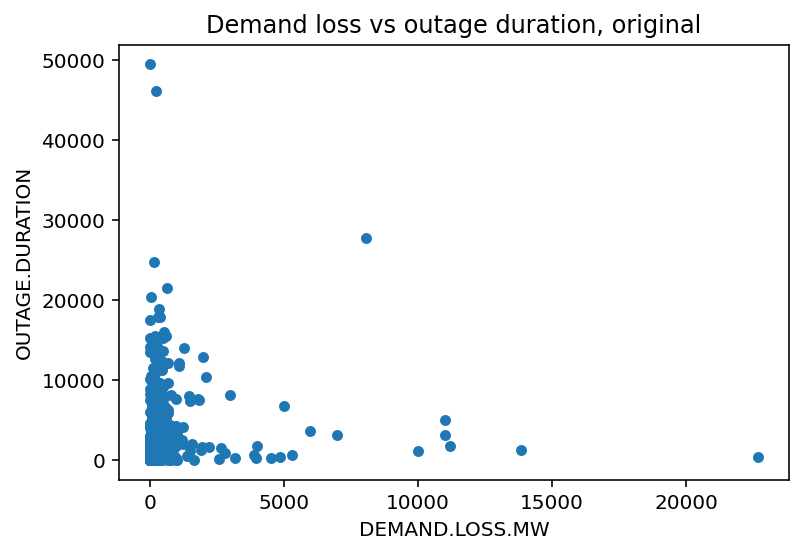

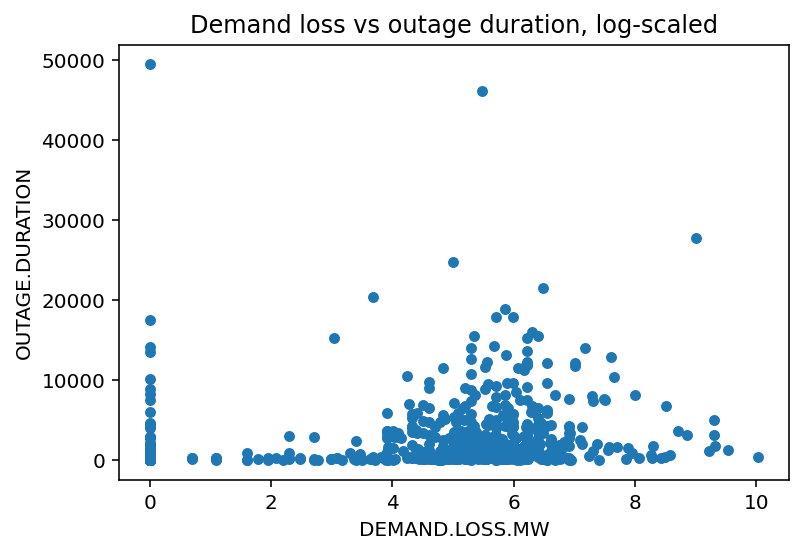

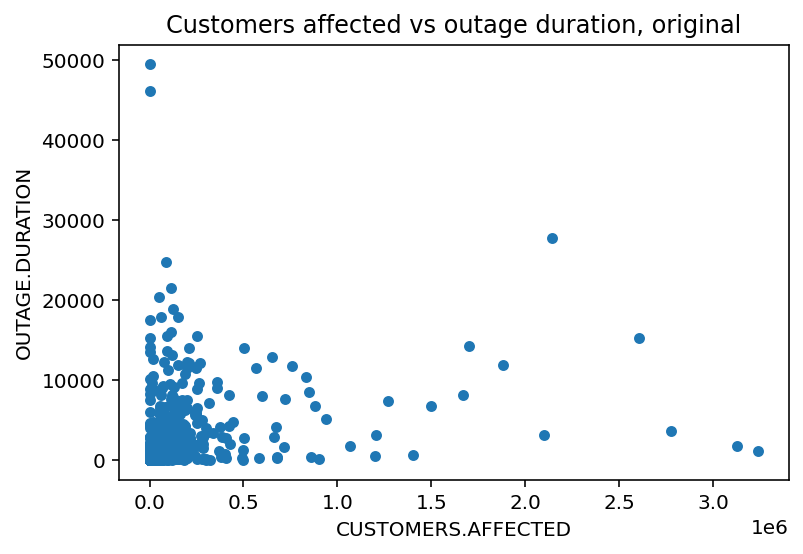

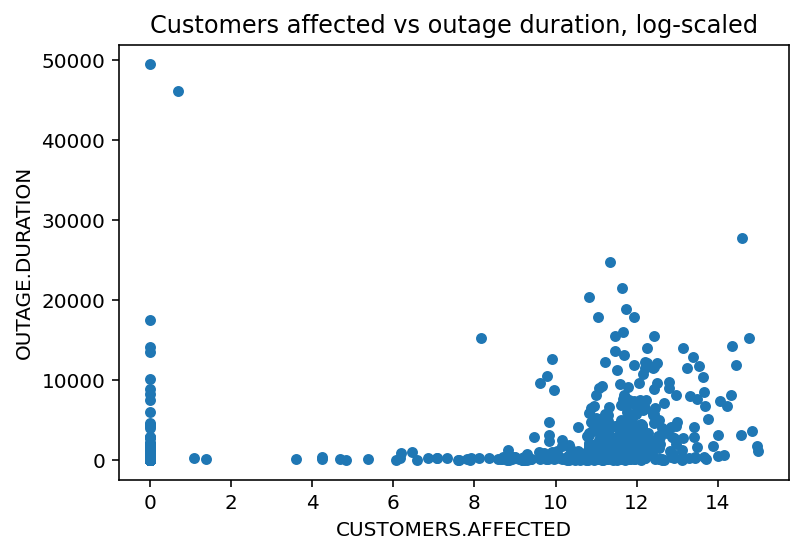

In [821]:
# visualizations of pre log-scaled and post log scaled columns
# demand loss
df[['DEMAND.LOSS.MW', 'OUTAGE.DURATION']].plot(kind='scatter', x='DEMAND.LOSS.MW', y='OUTAGE.DURATION', title='Demand loss vs outage duration, original')
demand_loss_log = np.log(df['DEMAND.LOSS.MW'].astype(float)).astype(str).replace(to_replace='-inf', value=0).astype(float)
dl_graph = pd.concat([df['OUTAGE.DURATION'], demand_loss_log], axis=1)
dl_graph.plot(kind='scatter', x='DEMAND.LOSS.MW', y='OUTAGE.DURATION', title='Demand loss vs outage duration, log-scaled')
# assigning back to original features df
df['demand_loss_log'] = demand_loss_log

# customers affected
df[['CUSTOMERS.AFFECTED', 'OUTAGE.DURATION']].plot(kind='scatter', x='CUSTOMERS.AFFECTED', y='OUTAGE.DURATION', title='Customers affected vs outage duration, original')
customers_affected_log = np.log(df['CUSTOMERS.AFFECTED'].astype(float)).astype(str).replace(to_replace='-inf', value=0).astype(float)
ca_graph = pd.concat([df['OUTAGE.DURATION'], customers_affected_log], axis=1)
ca_graph.plot(kind='scatter', x='CUSTOMERS.AFFECTED', y='OUTAGE.DURATION', title='Customers affected vs outage duration, log-scaled')
# assigning back to original features df
df['customers_affected_log'] = customers_affected_log


For the categorical features, I see that I could adjust the MONTHS column and group them together into four quarters/seasons. Months 12, 1, 2 are winter; 3, 4, 5 are spring; 6, 7, 8 are summer, 9, 10, 11 are autumn, and then I can reperform one-hot encoding on these new grouped categorical features.

In [822]:
# helper function to bin/categorize months into seasons
def grouped_months(x):
    if x == 12 or x == 1 or x == 2:
        return 'winter'
    if x == 3 or x == 4 or x == 5:
        return 'spring'
    if x == 6 or x == 7 or x == 8:
        return 'summer'
    if x == 9 or x == 10 or x == 11:
        return 'autumn'
    

In [824]:
unchanged_feat_cat = ['U.S._STATE', 'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY']
unchanged_feat_quant = ['ANOMALY.LEVEL']
changed_cat = ['seasons']
changed_quant = ['DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED']

In [862]:
# new_features = df[['MONTH', 'U.S._STATE', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED']]
new_features = df.copy()
new_features['seasons'] = df['MONTH'].apply(grouped_months)
new_features = new_features.drop(columns='MONTH')
new_features

,U.S._STATE,ANOMALY.LEVEL,CLIMATE.REGION,CLIMATE.CATEGORY,CAUSE.CATEGORY,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,OUTAGE.DURATION,severe=True,demand_loss_log,customers_affected_log,seasons
0,Minnesota,1.2,East North Central,warm,severe weather,250,250000,1740,0.0,5.521461,12.429216,summer
1,Minnesota,0.2,East North Central,normal,severe weather,75,300000,3960,1.0,4.317488,12.611538,summer
2,Minnesota,0.6,East North Central,warm,intentional attack,20,5941,155,0.0,2.995732,8.689633,spring
3,Minnesota,-0.3,East North Central,normal,intentional attack,0,0,0,0.0,0.000000,0.000000,summer
4,Minnesota,-0.4,East North Central,normal,intentional attack,0,0,1322,0.0,0.000000,0.000000,spring
...,...,...,...,...,...,...,...,...,...,...,...,...
683,Idaho,0.3,Northwest,normal,system operability disruption,157,35000,95,0.0,5.056246,10.463103,summer
684,Idaho,-1.3,Northwest,cold,intentional attack,0,0,360,0.0,0.000000,0.000000,winter
685,Idaho,-0.1,Northwest,normal,public appeal,0,0,1548,0.0,0.000000,0.000000,summer
686,Idaho,1.6,Northwest,warm,intentional attack,0,0,0,0.0,0.000000,0.000000,spring


In [863]:
new_features['DEMAND.LOSS.MW'] = new_features['DEMAND.LOSS.MW'].astype(float)
new_features['CUSTOMERS.AFFECTED'] = new_features['CUSTOMERS.AFFECTED'].astype(float)

In [1091]:
def final_model(df):
    y = df['severe=True']
    X = df.drop(columns=['OUTAGE.DURATION', 'severe=True'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    one_hot = OneHotEncoder(handle_unknown='ignore')
    log_func = FunctionTransformer(np.log1p)
    quant_func = FunctionTransformer(lambda x: x)


    col_trans = (ColumnTransformer([('cat1', one_hot, unchanged_feat_cat), 
                                    ('cat2', one_hot, changed_cat), 
                                    ('quant1', log_func, changed_quant), 
                                    ('quant2', quant_func, unchanged_feat_quant)]))
    decision_tree = DecisionTreeClassifier(max_depth = 15)
    final_pl = Pipeline([('ct', col_trans), ('dtc', decision_tree)])

    # fitting model with training data
    fit = final_pl.fit(X_train, y_train)
    preds = final_pl.predict(X_test)

    # printing out different metrics from testing
    accuracy = metrics.accuracy_score(y_test, preds)
    recall = metrics.recall_score(y_test, preds)
    precision = metrics.precision_score(y_test, preds)
    f1_score = f1_scored(y_test, preds)

#     print('The accuracy score is ' + str(accuracy))
#     print('The recall score is ' + str(recall))
#     print('The precision score is ' + str(precision))
#     print('The f1 score is ' + str(f1_score))
    return [precision, f1_score]

print('The final model\'s f1 score is: ' + str(final_model(new_features)[1]))

The final model's f1 score is: 0.7012987012987012


After engineering new features, the final model now gives us an f1 score of around 0.7, an improvement over our baseline model. Now I perform a grid search to explore parameter combinations using cross-validation.

In [1022]:
parameters = {
    'dtc__max_depth': [2,3,4,5,7,10,13,15], 
    'dtc__min_samples_split':[2, 3, 5, 9, 12, 15],
    'dtc__min_samples_leaf':[2, 3, 5, 9, 12, 15]
}

clf = GridSearchCV(final_pl, parameters, cv = 5)
clf.fit(X_train, y_train)
# final_pl.get_params().keys()
clf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('cat1',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['U.S._STATE',
                                                                          'CLIMATE.REGION',
                                                                          'CLIMATE.CATEGORY',
                                                                          'CAUSE.CATEGORY']),
                                                                        ('cat2',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['seasons']),
                                                                        ('quant1',
         

In [1023]:
clf.best_params_

{'dtc__max_depth': 5, 'dtc__min_samples_leaf': 5, 'dtc__min_samples_split': 9}

### Fairness Evaluation

Here I perform a permutation test to evaluate my model for fairness.

In [1093]:
# permutation test

new_features_copy = new_features.copy()
obs = abs(final_model(less)[0] - final_model(more)[0])

# splitting the dataset into two, less and more demand loss
median = new_features['DEMAND.LOSS.MW'].median()
less = (
    new_features[new_features['DEMAND.LOSS.MW'] 
                 <= median].reset_index(drop=True))
more = (new_features[new_features['DEMAND.LOSS.MW'] 
                     > median].reset_index(drop=True))

# 500 repetitions
N = 500

lst = []
for _ in range(N):
    new_features_copy['DEMAND.LOSS.MW'] = (
        np.random.permutation(new_features_copy['DEMAND.LOSS.MW'])
    )
    diff = abs(final_model(less)[0] - final_model(more)[0])
    lst.append(diff)
    
p_val = np.count_nonzero(np.array(lst) > obs) / N
p_val


0.608

Since our p-value is 0.608, and our significance level is 0.05, this means we cannot reject the null hypothesis, supporting that my model is fair and the precision for my two subsets are about the same.